In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
import tabulate as tab
import glob

In [2]:
def get_info(akw, display=False):
    # akw['waveformsADC'][trigRec][chID]
    Nevents    = len(akw['waveformsADC'])
    TrigWindow = len(akw['waveformsADC'][0][0])
    Nchannels  = len(akw['waveformsADC'][0])
    maxima = []
    for chID in range(0, Nchannels):
        maxima.append(ak.max( akw['waveformsADC'][:][chID]) )
    if display:
        print(' events', Nevents)
        print(' trigger window', TrigWindow)
        print(' number of channels', Nchannels)
        print(' max height', int(np.max(maxima)) )
    return Nevents, TrigWindow, Nchannels, maxima

In [3]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'
filepath = f'{cernbox}/anaCRP_files'

In [4]:
files = glob.glob(f"{filepath}/pns_nTuples_r25036_*.pkl")
pns = {}
for file in files:
    with open(file, "rb") as f:
        pns.update(pickle.load(f))

In [5]:
files = glob.glob(f"{filepath}/cos_nTuples_r25004_*.pkl")
cos = {}
for file in files:
    with open(file, "rb") as f:
        cos.update(pickle.load(f))

In [6]:
print('PNS')
_, _, _, _ = get_info(pns, display=True)
print('Cosmics')
_, _, _, _ = get_info(cos, display=True)

PNS
 events 4648
 trigger window 65600
 number of channels 12
 max height 16383
Cosmics
 events 756
 trigger window 262208
 number of channels 12
 max height 16383


## 

# Pedestal Subtraction

## Flag events with unstable baseline

In [7]:
def estimate_baseline_stability(waveform, max_deviation=5):
    median = np.median(waveform)
    mad = np.median(np.abs(waveform - median))

    quiet = np.abs(waveform - median) < max_deviation * mad

    if not np.any(quiet):  # if mask is empty
        return np.nan, np.nan, quiet ### maybe should return an arbitrary high number instead (e.g. 99999)

    baseline = np.mean(waveform[quiet])
    rms = np.std(waveform[quiet])
    return baseline, rms, quiet

def add_baseline_stability_estimate(sample):
    wfs = sample['waveformsADC']
    Nevents, _, Nchannels, _ = get_info(sample, display=False)
    sample['baseline_stability'] = np.array([[estimate_baseline_stability(wfs[trigID, chID], max_deviation=5)[1] for chID in range(Nchannels)] for trigID in range(Nevents)])



In [8]:
add_baseline_stability_estimate(pns)
add_baseline_stability_estimate(cos)

In [9]:
cut = 40
lines = [['channel', 'PNS rejection [%]', 'Cosmics rejection [%]']]
rej_pns, rej_cos = [], []
Nevents_pns, _, Nchannels, _ = get_info(pns, display=False)
Nevents_cos, _, Nchannels, _ = get_info(cos, display=False)
for chID in range(Nchannels):
    sel_pns = pns['baseline_stability'][pns['baseline_stability'][:, chID]>40][:,chID]
    rej_pns.append(sel_pns.shape[0]*100/Nevents_pns)
    sel_cos = cos['baseline_stability'][cos['baseline_stability'][:, chID]>40][:,chID]
    rej_cos.append(sel_cos.shape[0]*100/Nevents_cos)
    lines.append( [chID, f'{rej_pns[chID]:.1f}', f'{rej_cos[chID]:.1f}'] )
print(tab.tabulate(lines, headers="firstrow", tablefmt="github"))

|   channel |   PNS rejection [%] |   Cosmics rejection [%] |
|-----------|---------------------|-------------------------|
|         0 |                 9   |                     2.1 |
|         1 |                 2.3 |                    11.5 |
|         2 |                 8.6 |                    16.7 |
|         3 |                 8.4 |                     7.5 |
|         4 |                 6.7 |                    15.9 |
|         5 |                49.2 |                    13.8 |
|         6 |                99.2 |                    48   |
|         7 |                 0   |                     0   |
|         8 |                28.8 |                    36.8 |
|         9 |                 0   |                   100   |
|        10 |               100   |                     0   |
|        11 |                 0   |                     0   |


# Extract Peaks

In [10]:
from scipy.signal import find_peaks

def find_peaks_2d(array_trigRecxTT, **kwargs):
    """
    Find peaks in a 2D waveform array (trigRec x tt).
    
    Args:
        array_2d: np.ndarray shape (N_trigRecs, N_tt)
        kwargs: arguments for `scipy.signal.find_peaks`, e.g. height, distance, width

    Returns:
        dict with:
            - 'peak_indices': list of np.arrays with peak positions
            - 'peak_heights': list of np.arrays with peak heights
            - 'properties': list of full peak properties per waveform
            - 'pulses': list of slices around peaks (if width info available)
    """
    props_list = []
    peak_indices = []
    peak_heights = []
    peak_slices = []

    for row_idx, row in enumerate(array_trigRecxTT):
        peaks, props = find_peaks(row, **kwargs)

        # getters
        heights  = props.get("peak_heights", row[peaks])
        # left_ips = props.get("left_ips", props)

        # Extract waveform slices around peaks (if widths are calculated)
        slices = []
        if "left_ips" in props and "right_ips" in props:
            for l, r in zip(props["left_ips"], props["right_ips"]):
                start = max(0, int(np.floor(l)))
                end   = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [np.array([row[p]]) for p in peaks]  # fallback: just peak value

        # Collect
        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        peak_slices.append(slices)

    return {
        "peak_indices": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "pulses": peak_slices,
    }

def test_plot(result, waveform, chID, trigRec, avg=True, few_pulses=None):
    print('Selection applied to test plot:')
    print('  - remove stauration')
    print('  - subtract pedestal')
    fig, axs = plt.subplots(1, 2, figsize=(11, 3))
    peak_indices = result['peak_indices'][trigRec]
    full_waveform = waveform['waveformsADC'][trigRec, chID]
    ax = axs[0]
    ax.plot(full_waveform, label="Trigger Record")
    ax.plot(peak_indices, full_waveform[peak_indices], "rx", label="Peaks")
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')

    _, _, _, maxima = get_info(waveform, display=False)
    ADCsat = int(np.max(maxima))
    wfs_pns = []
    pedestal = waveform['pedestals'][trigRec, chID] 
    pedestal
    wfs_pns  = [w - pedestal for w in result['pulses'][trigRec]]
    ax = axs[1]
    pulses_noSat = []
    if few_pulses is not None:
        wfs_pns = wfs_pns[few_pulses[0]:few_pulses[1]]
    for pulse in wfs_pns:
        if np.max(pulse)<ADCsat:
            ax.plot( pulse );
        pulses_noSat.append(pulse)
    if avg:
        avg_pns = ak.mean(pulses_noSat, axis=0)
        ax.plot(avg_pns, color='black', label='average')
        ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC - pedestal');
    return wfs_pns

def apply_selection(result, sample, chID, rms_cut, max_peak_position, remove_pedestal=True):
    print('Selection:')
    print(f'  1. remove stauration')
    if remove_pedestal: print(f'  2. subtract pedestal')
    if rms_cut is not None: print(f'  3. use only trigger records with stable baseline (rms_cut = {rms_cut})')
    if max_peak_position is not None: print(f'  4. peak position < {max_peak_position}')

    _, _, _, maxima = get_info(sample, display=False)
    
    # 1. remove saturation
    ADCsat = int(np.max(maxima))
    step1 = [[pulse for pulse in trigRec if np.max(pulse)<ADCsat] for trigRec in result['pulses'] ]
    
    # 2. subtract pedestal
    if remove_pedestal:
        pedestals = sample['pedestals'][:, chID] 
        step2  = [[pulse-pedestals[i] for pulse in step1[i]] for i in range(len(step1))]
    else:
        step2  = step1

    # 3. use only trigger records with stable baseline
    if rms_cut is not None:
        baseline_stability = sample['baseline_stability'][:, chID] 
        step3  = [[pulse for pulse in step2[i] if baseline_stability[i]<rms_cut] for i in range(len(step2))]
    else:
        step3 = step2

    # 4. cut on peak position
    if max_peak_position is not None:
        step4  = [[pulse for pulse in step3[i] if np.argmax(pulse)<max_peak_position] for i in range(len(step3))]
    else:
        step4 = step3

    selection = step4
    
    return selection

In [11]:
rms_cut = 40
max_peak_position = 30
Nchannels = 9

pns_channels, cos_channels = [], []
for chID in range(Nchannels):
    pns_result = find_peaks_2d(pns['waveformsADC'][:, chID],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
    cos_result = find_peaks_2d(cos['waveformsADC'][:, chID],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
    selected_pulses_pns = apply_selection(pns_result, pns, chID, rms_cut=rms_cut, max_peak_position=max_peak_position, remove_pedestal=True)
    selected_pulses_pns  = [[pulse for pulse in selected_pulses_pns[i] if len(pulse)>100] for i in range(len(selected_pulses_pns))]
    print('  5. discard pulses shorter than 100 time ticks')
    pulses_flat_pns = [sub for group in selected_pulses_pns for sub in group]
    selected_pulses_cos = apply_selection(cos_result, cos, chID, rms_cut=rms_cut, max_peak_position=max_peak_position, remove_pedestal=True)
    selected_pulses_cos  = [[pulse for pulse in selected_pulses_cos[i] if len(pulse)>100] for i in range(len(selected_pulses_cos))]
    print('  5. discard pulses shorter than 100 time ticks')
    pulses_flat_cos = [sub for group in selected_pulses_cos for sub in group]
    single_peak_flat_pns = []
    for wf in pulses_flat_pns:
        peaks, props = find_peaks(wf, distance=None, prominence=50, wlen=None)
        if len(peaks)<2:
            single_peak_flat_pns.append(wf)
    single_peak_flat_cos = []
    for wf in pulses_flat_cos:
        peaks, props = find_peaks(wf, distance=None, prominence=50, wlen=None)
        if len(peaks)<2:
            single_peak_flat_cos.append(wf)
    pns_channels.append(single_peak_flat_pns)
    cos_channels.append(single_peak_flat_cos)


/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_62395/3944102308.py:24: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks
Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks
Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks
Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks
Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks
Selection:
  1. remove st

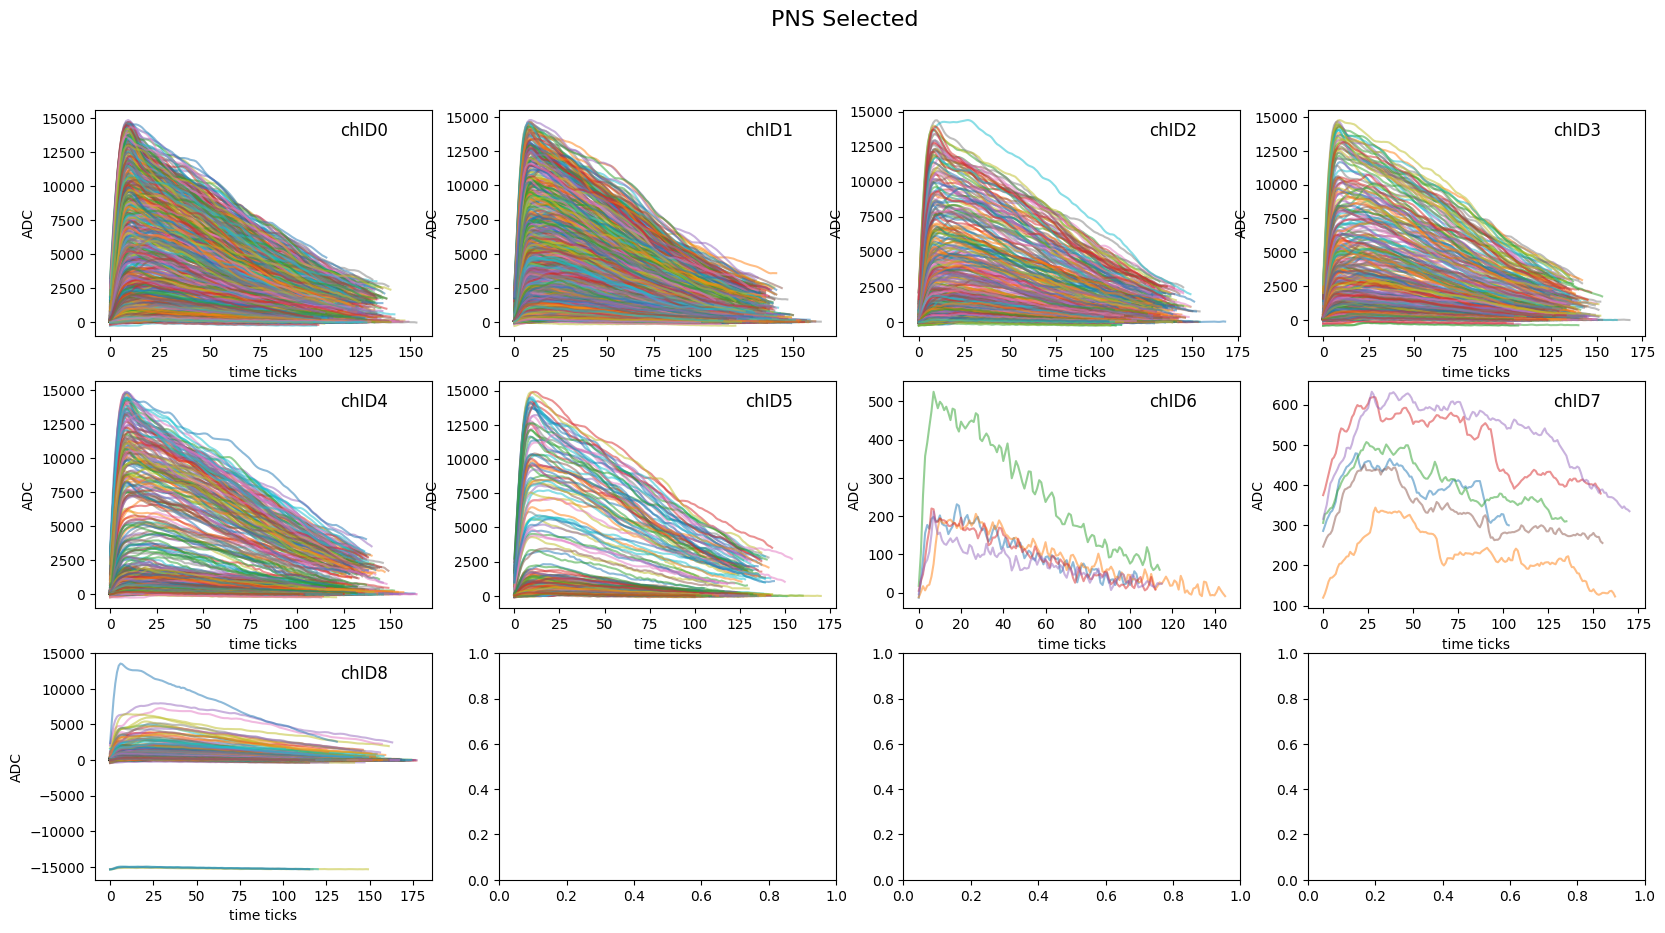

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'PNS Selected', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    for p in range(len(pns_channels[chID])):
        ax.plot(pns_channels[chID][p], alpha=0.5)
    # ax.plot(ak.mean(cos_channels[chID], axis=0), linewidth=2, label='Cosmics')
    # if chID==0: ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
plt.show()

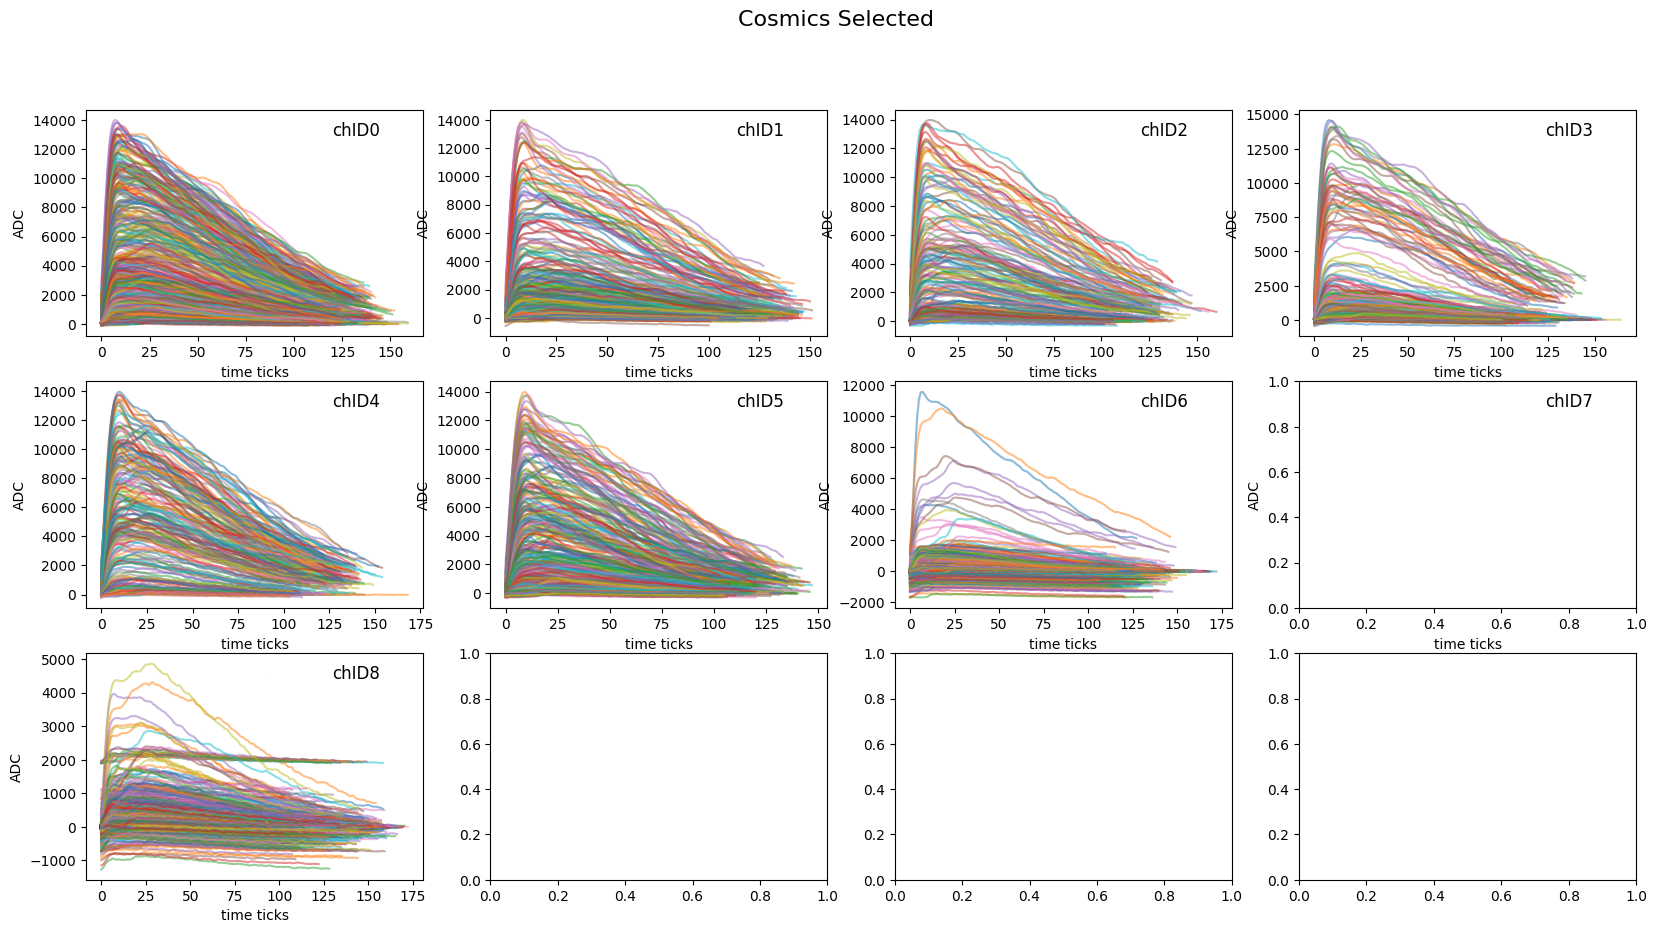

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'Cosmics Selected', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    for p in range(len(cos_channels[chID])):
        ax.plot(cos_channels[chID][p], alpha=0.5)
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
plt.show()

In [ ]:
# def find_rising_edge_index(wf, frac=0.1):
#     """Find index where waveform first exceeds frac*max."""
#     threshold = frac * np.max(wf)
#     idx = np.where(wf >= threshold)[0]
#     return idx[0] if len(idx) > 0 else None

# # Example: align all waveforms by rising edge
# aligned_wfs = []
# target_index = 50  # where you want rising edges aligned

# for wf in waveforms:
#     idx_rise = find_rising_edge_index(wf, frac=0.1)
#     if idx_rise is None:
#         continue  # skip if no rising edge found

#     shift = target_index - idx_rise
#     aligned = np.roll(wf, shift)
#     aligned_wfs.append(aligned)

# aligned_wfs = np.array(aligned_wfs)

# # Plot
# plt.figure(figsize=(8, 5))
# for wf in aligned_wfs:
#     plt.plot(wf, alpha=0.5)
# plt.title("Waveforms aligned by rising edge")
# plt.xlabel("Sample")
# plt.ylabel("ADC counts")
# plt.show()

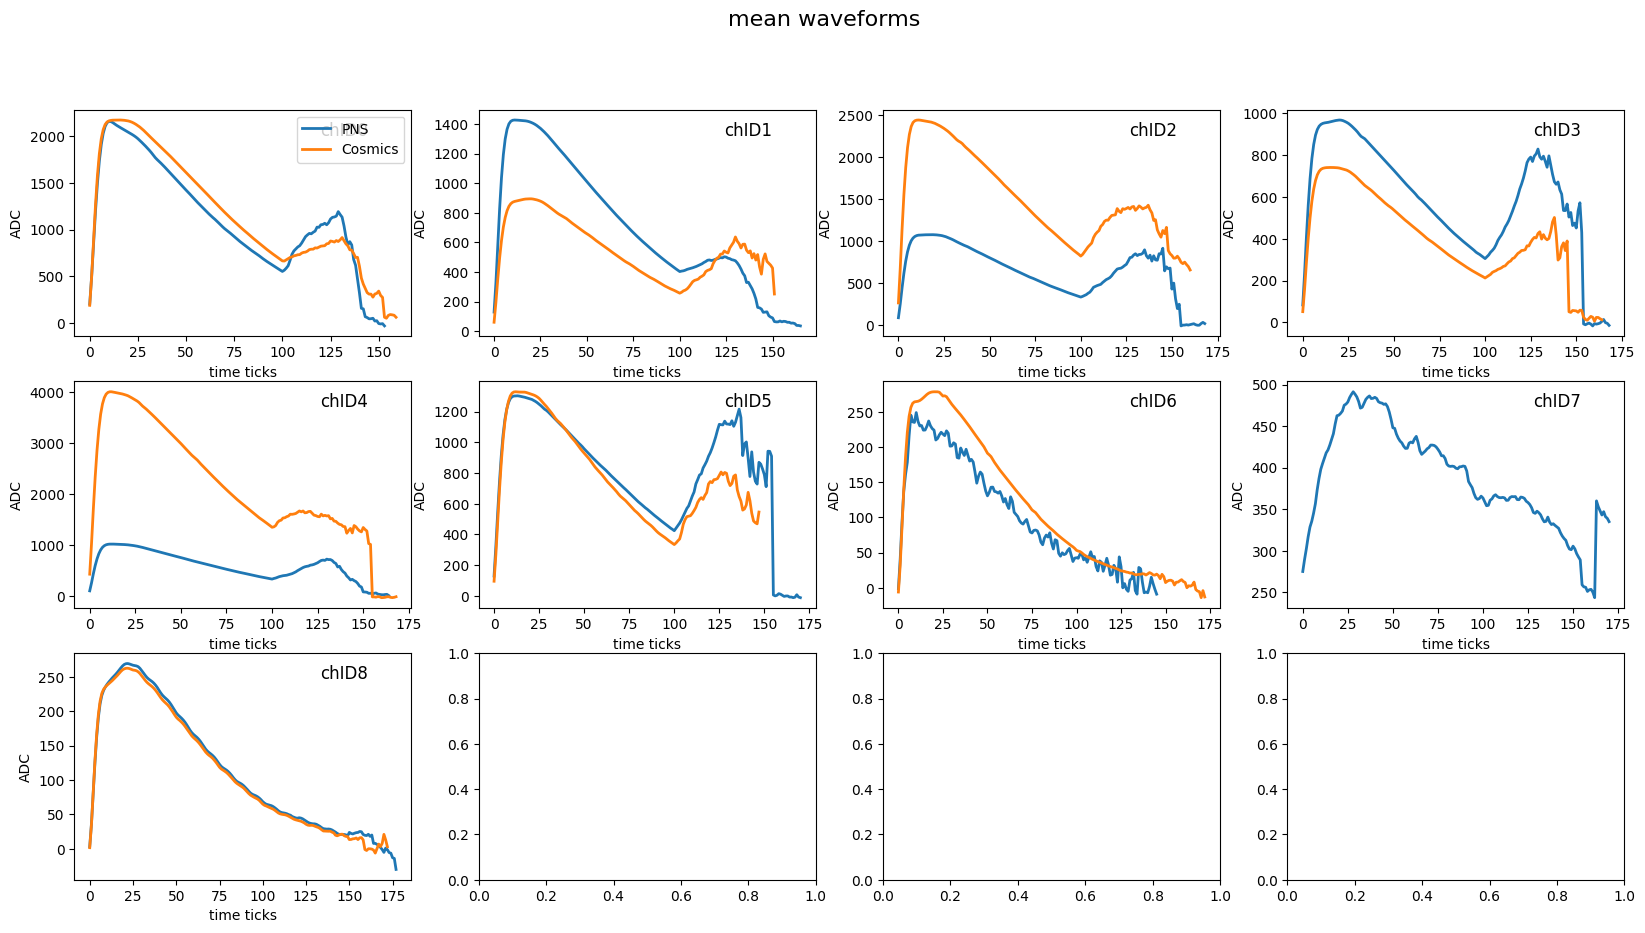

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'mean waveforms', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    ax.plot(ak.mean(pns_channels[chID], axis=0), linewidth=2, label='PNS')
    ax.plot(ak.mean(cos_channels[chID], axis=0), linewidth=2, label='Cosmics')
    if chID==0: ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
plt.show()

# PSD

In [75]:
def prompt_frac(waveforms, tot_int_boundaries, prompt_int_boundaries):
    promptFrac, Int, ratio = [], [], []
    for p in waveforms:
        peak_position = p.argmax()
        lim_inf = peak_position+prompt_int_boundaries[0]
        lim_sup = peak_position+prompt_int_boundaries[1]
        if lim_inf<0:
            lim_inf = 0
        pf = p[lim_inf:lim_sup].sum()
        integ = p[tot_int_boundaries[0]:tot_int_boundaries[1]].sum()
        r = pf/integ
        promptFrac.append( pf )
        Int.append( integ )
        ratio.append( r )
    return np.array(Int), np.array(ratio)

In [76]:
## Vitaliy's choices
bmin_baseline, bmax_baseline = (0, 300)
prompt_boundaries = (-20,  33)


/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


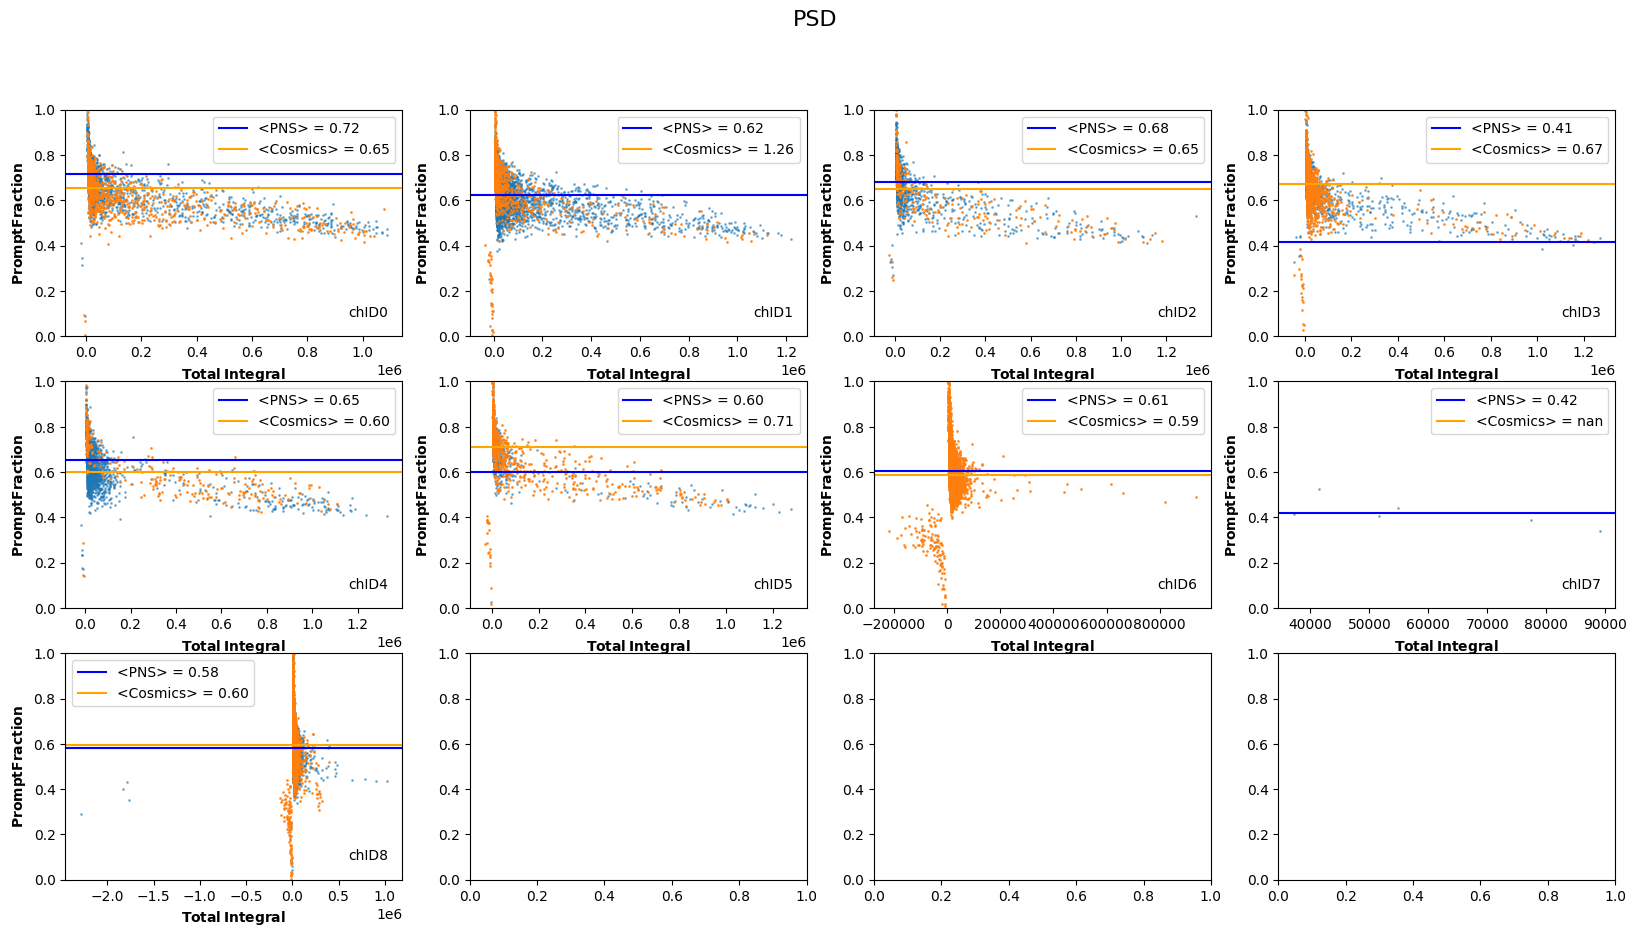

In [77]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'PSD', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    Int_baseline, ratio_baseline = prompt_frac(pns_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5)
    mean = np.mean(ratio_baseline)
    ax.axhline(y = mean, color='blue', label=f'<PNS> = {mean:.2f}')
    Int_baseline, ratio_baseline = prompt_frac(cos_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8)
    mean = np.mean(ratio_baseline)
    ax.axhline(y = mean, color='orange', label=f'<Cosmics> = {mean:.2f}')
    ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
    ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$")
    ax.set_title(f'chID{chID}', x=0.9,  y = 0.05, fontsize=10)
    ax.legend()
    ax.set_ylim(0, 1);
plt.show()

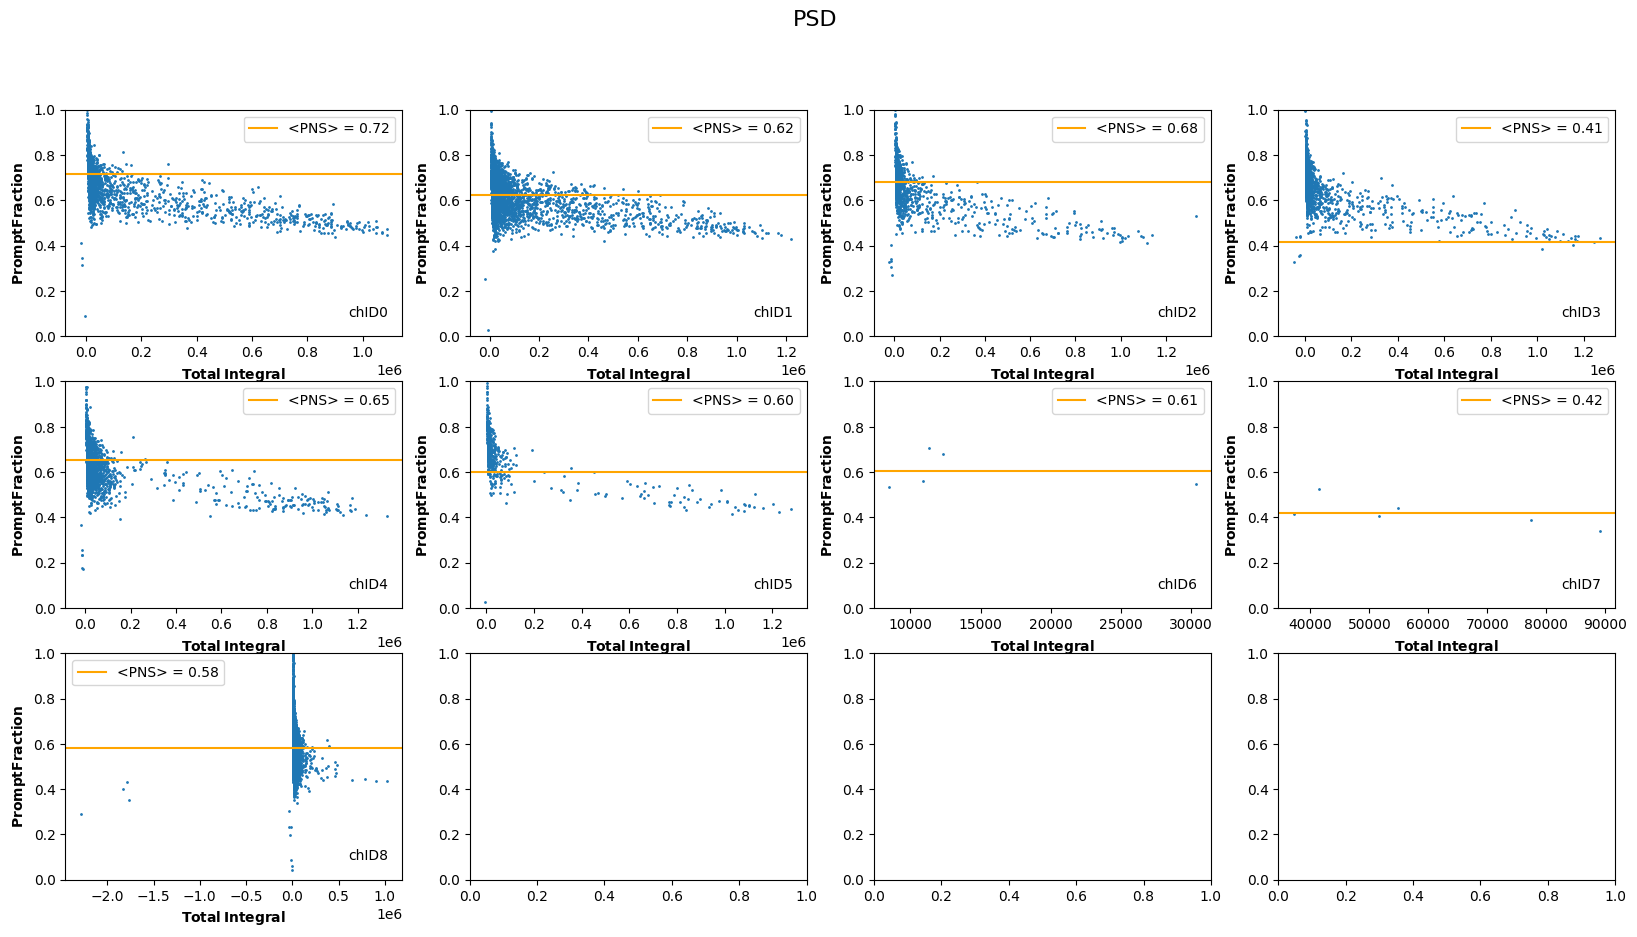

In [78]:
# bmin_baseline, bmax_baseline = (0, 100)
# prompt_boundaries = (-20,  30)


fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'PSD', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    Int_baseline_pns, ratio_baseline_pns = prompt_frac(pns_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline_pns, ratio_baseline_pns,  s=1)
    mean = np.mean(ratio_baseline_pns)
    ax.axhline(y = mean, color='orange', label=f'<PNS> = {mean:.2f}')
    ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
    ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$")
    ax.set_title(f'chID{chID}', x=0.9,  y = 0.05, fontsize=10)
    ax.legend()
    ax.set_ylim(0, 1);
plt.show()

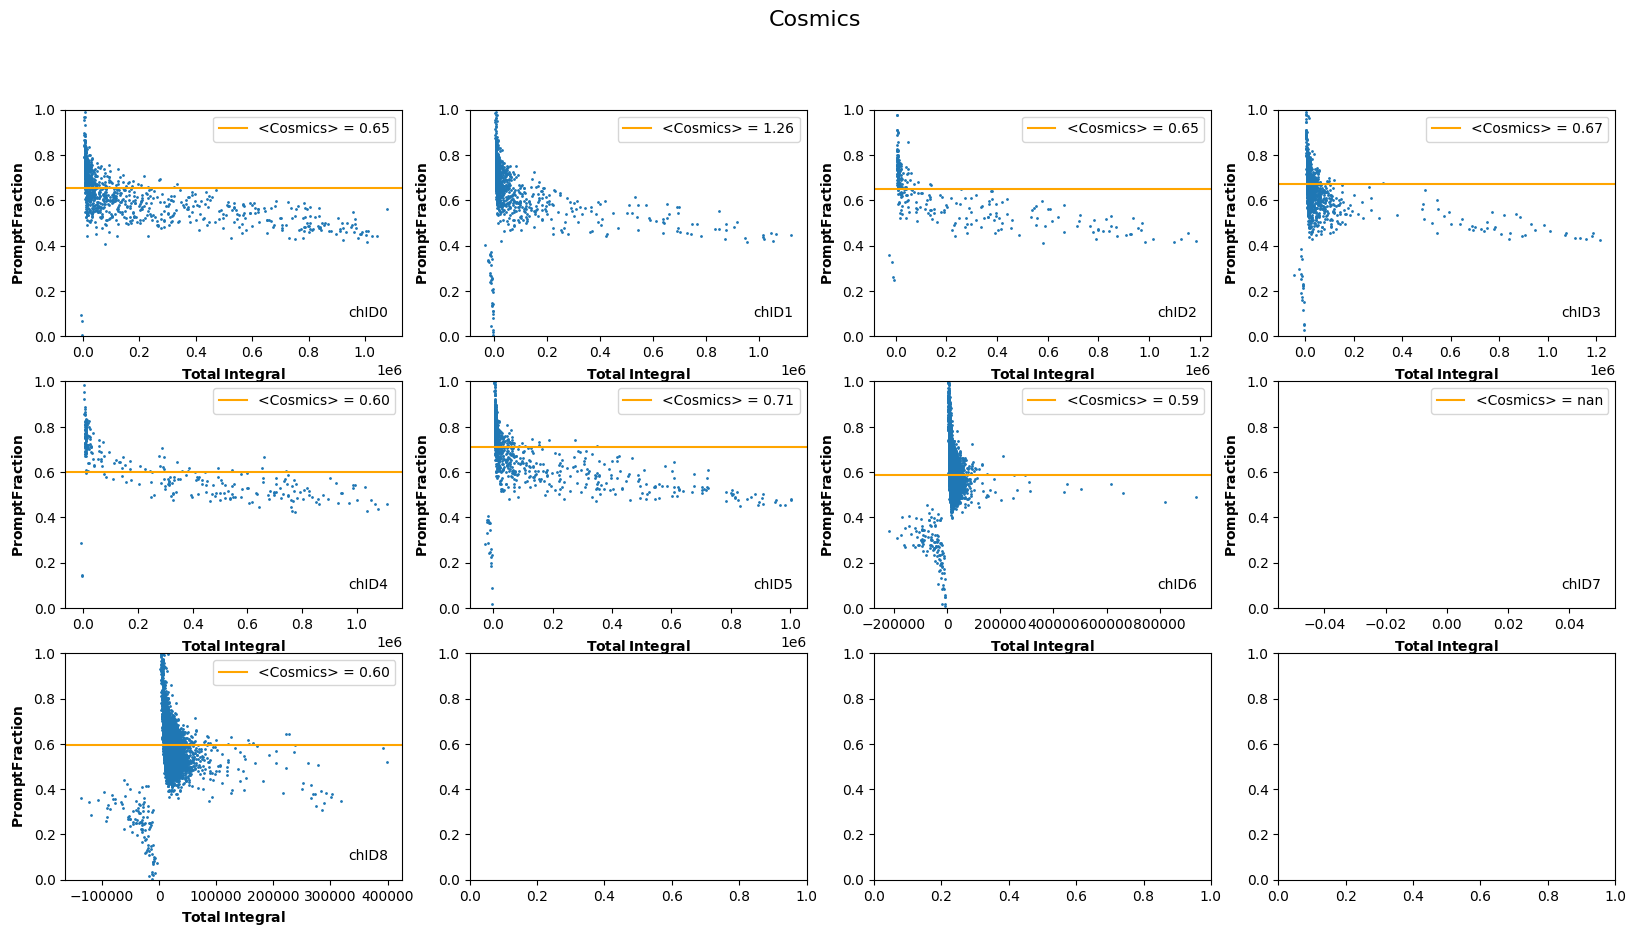

In [79]:
# bmin_baseline, bmax_baseline = (0, 100)
# prompt_boundaries = (-20,  20)


fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'Cosmics', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    Int_baseline_cos, ratio_baseline_cos = prompt_frac(cos_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline_cos, ratio_baseline_cos,  s=1)
    mean = np.mean(ratio_baseline_cos)
    ax.axhline(y = mean, color='orange', label=f'<Cosmics> = {mean:.2f}')
    ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
    ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$")
    ax.set_title(f'chID{chID}', x=0.9,  y = 0.05, fontsize=10)
    ax.legend()
    ax.set_ylim(0, 1);
plt.show()

# Focus on a few channels

In [82]:
# ## Vitaliy's choices
bmin_baseline, bmax_baseline = (0, 300)
prompt_boundaries = (-20,  33)

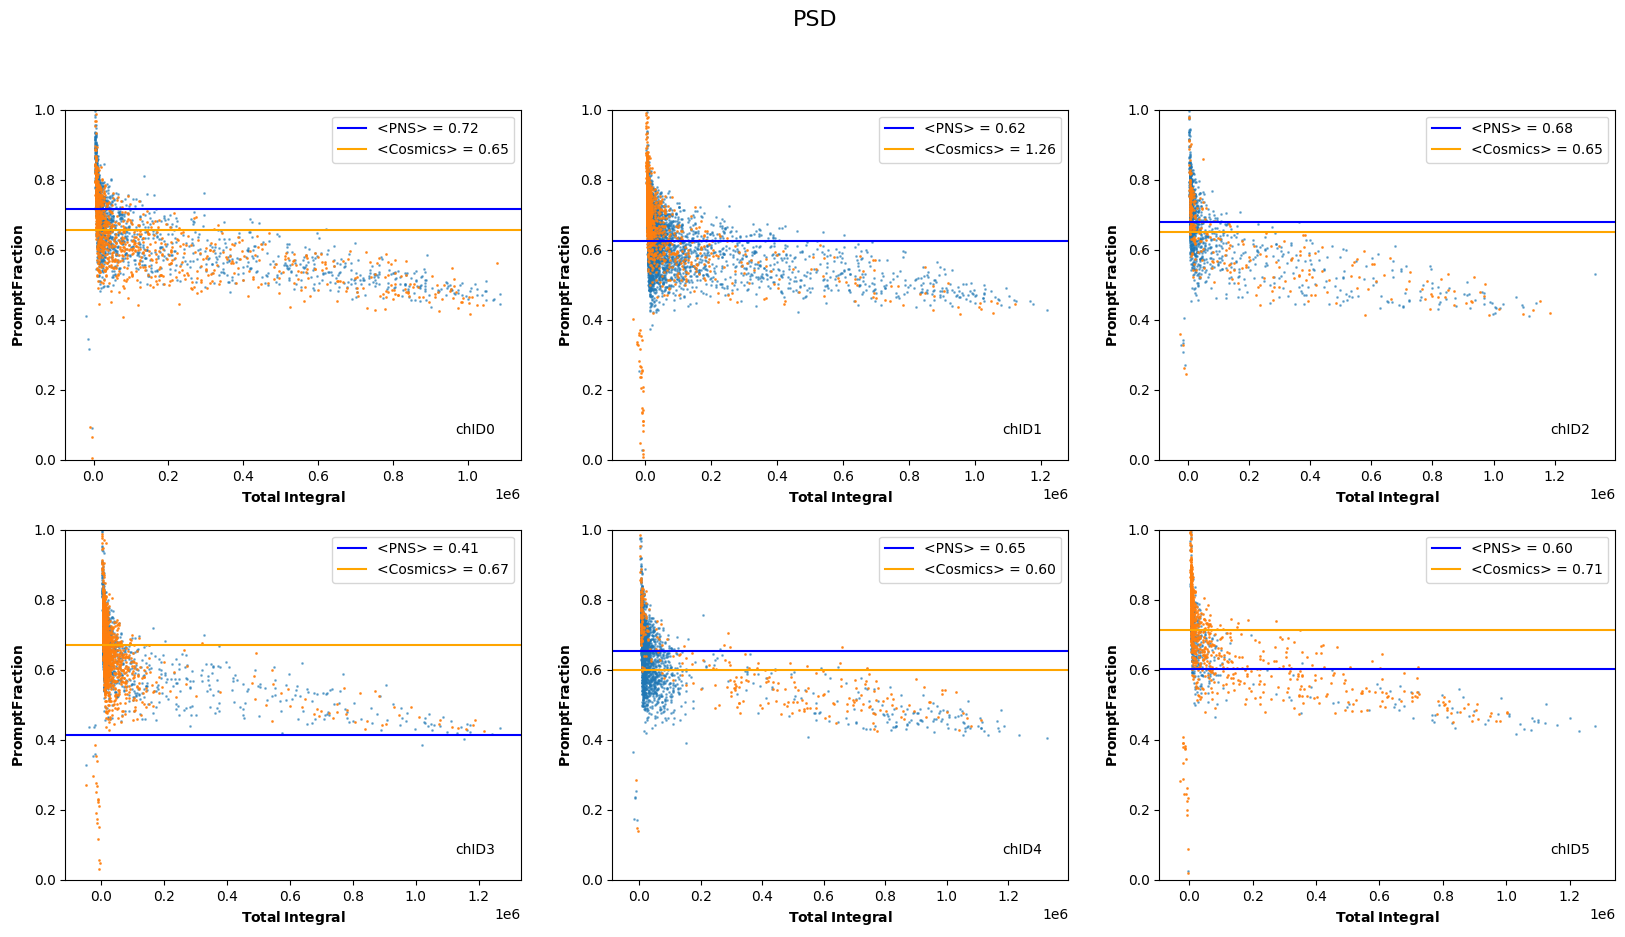

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle(f'PSD', fontsize=16)
for chID in range(6):
    ax = axs.flatten()[chID]
    Int_baseline, ratio_baseline = prompt_frac(pns_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5)
    mean = np.mean(ratio_baseline)
    ax.axhline(y = mean, color='blue', label=f'<PNS> = {mean:.2f}')
    Int_baseline, ratio_baseline = prompt_frac(cos_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8)
    mean = np.mean(ratio_baseline)
    ax.axhline(y = mean, color='orange', label=f'<Cosmics> = {mean:.2f}')
    ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
    ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$")
    ax.set_title(f'chID{chID}', x=0.9,  y = 0.05, fontsize=10)
    ax.legend()
    ax.set_ylim(0, 1);
plt.show()

/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_62395/2149479718.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  r = pf/integ


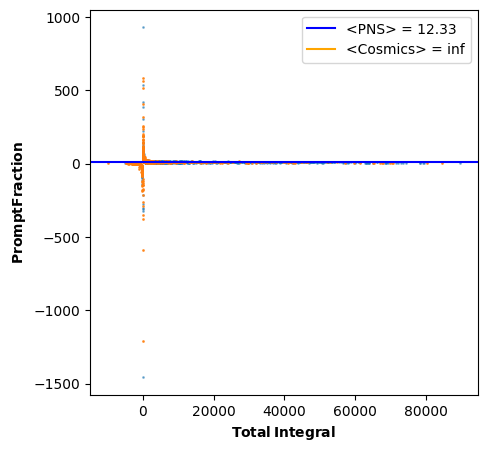

In [ ]:
def prompt_frac_with_sel(waveforms, tot_int_boundaries, prompt_int_boundaries):
    promptFrac, Int, ratio = [], [], []
    for p in waveforms:
        peak_position = p.argmax()
        lim_inf = peak_position+prompt_int_boundaries[0]
        lim_sup = peak_position+prompt_int_boundaries[1]
        if lim_inf<0:
            lim_inf = 0
        pf = p[lim_inf:lim_sup].sum()
        integ = p[tot_int_boundaries[0]:tot_int_boundaries[1]].sum()
        r = pf/integ

        #DEBUG
        if r>1:
            print(f'prompt fraction = {pf}')
            print(f'total integral  = {integ}')
            print(f'ratio  = {r}')
            continue




        if -0.1<r<1.1:
            promptFrac.append( pf )
            Int.append( integ )
            ratio.append( r )
    return np.array(Int), np.array(ratio)



bmin_baseline, bmax_baseline = (-20, 300)
prompt_boundaries = (-20,  33)

chID = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
Int_baseline, ratio_baseline = prompt_frac_with_sel(pns_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5)
mean = np.mean(ratio_baseline)
ax.axhline(y = mean, color='blue', label=f'<PNS> = {mean:.2f}')
Int_baseline, ratio_baseline = prompt_frac_with_sel(cos_channels[chID], (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8)
mean = np.mean(ratio_baseline)
ax.axhline(y = mean, color='orange', label=f'<Cosmics> = {mean:.2f}')
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$")
ax.legend()
# ax.set_ylim(0, 1);